## Introduccion a GANS

Una red generativa adversarial (GAN) es una clase de aprendizaje automático diseñado por Ian Goodfellow y sus colegas en 2014. Dos redes neuronales compiten entre sí en un juego (en forma de juego de suma cero, donde la ganancia de un agente es pérdida de otro agente).

<img src="img/gan1.png" />

La idea es la siguiente: 

1) Existe una red neurnal llamada **generador** se encargar de generar nuevas imagenes, de una forma similar al decoder del variational AE visto la semana anterior. El generador se alimenta de un espacio latente.

2) Existe otra red neuronal llamada **disciminador** la cual aprende a diferenciar entre una imagen verdadera y una imagen generada. Esta red recibe una imagen de tamano [28 x 28] y devuelve un valor en un Dense de 1. Osea si el true o false, si la imagen es verdadera o falsa.

3) El objetivo es que el discrimiminador se equivoque, osea que logre aceptar una imagen generada como una imagen verdadera. 

4) El generador y el discriminador se conectan de la misma forma que lo hicimos con el AutoEncoder.

5) El discriminador se entrena primero, es decir, este aprende a diferenciar imagenes falsas (con ruido) y verdaderas. 

6) El generador se entrena luego. Se entrena el generados para generar imagenes falsas, y se usa el discriminador para validar. Aqui no vamos a entrenar mas el discriminador, por tanto se indica como "no entrenable".

Debido a estos pasos, no podemos entrenar el modelo con el metodo fit() de keras, porque ciertamente esto es algo diferente, entonces, tendremos que generar nuetro propio fit. Aqui lo llamaremos "train_gan"

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [3]:
# CARGAR FASHION MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train.shape

(55000, 28, 28)

### Arquitectura GAN

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

# codings, igual que el VAR AE
codings_size = 30

# generador
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

# discriminador
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

# GAN
gan = keras.models.Sequential([generator, discriminator])

# Binary Cross Entropy: pq nuestro GAN y el discriminador son clasificadores binarios
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

### Nuestro Custom Fit

In [7]:
# configuramos el dataset de tensorflow con 1000 imagenes aleatorias
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# Entrenamiento Fit
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    
    # obtenemos las capas del modelo por separado.
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for X_batch in dataset:
            
            # Fase 1 entrenamiento del discriminador
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # Fase 2 - entrenamiento del generador
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            
        # imprimir las imagenes generadas
        plot_multiple_images(generated_images, 8)                     
        plt.show()                                                    

Epoch 1/1


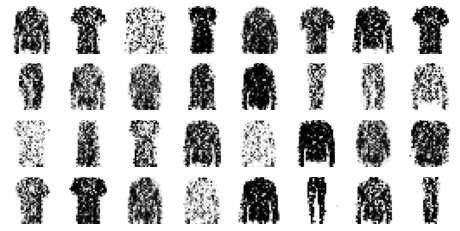

In [8]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

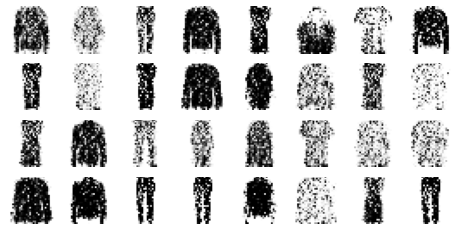

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

Epoch 1/50


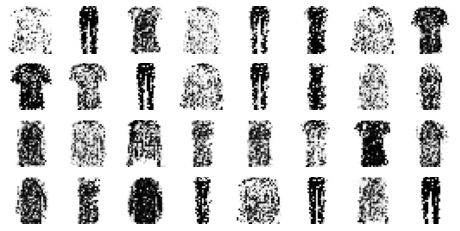

Epoch 2/50


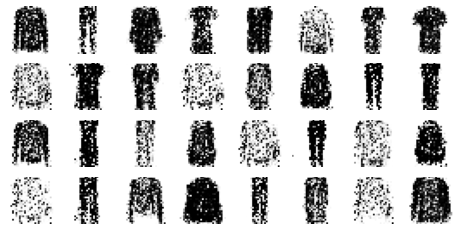

Epoch 3/50


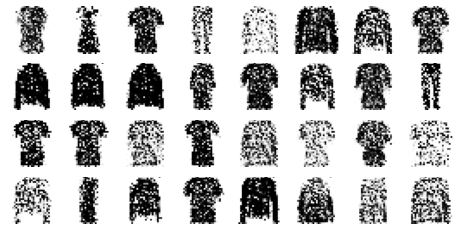

Epoch 4/50


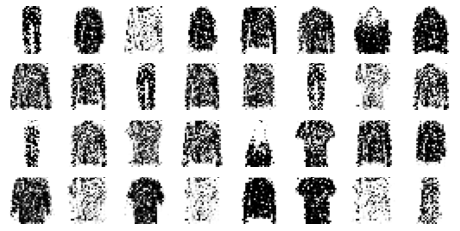

Epoch 5/50


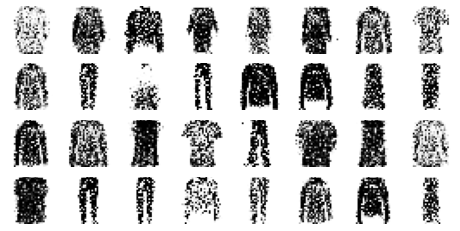

Epoch 6/50


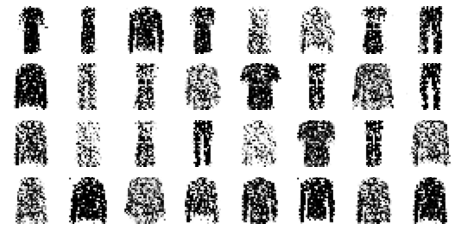

Epoch 7/50


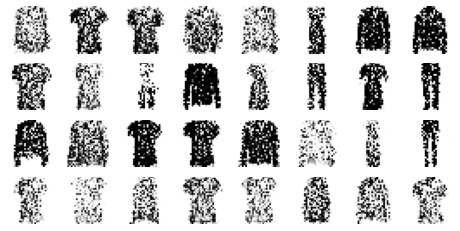

Epoch 8/50


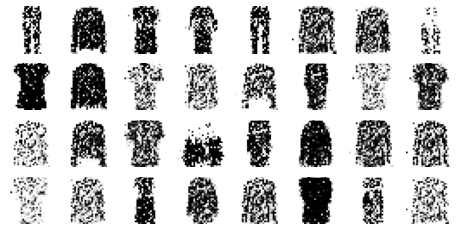

Epoch 9/50


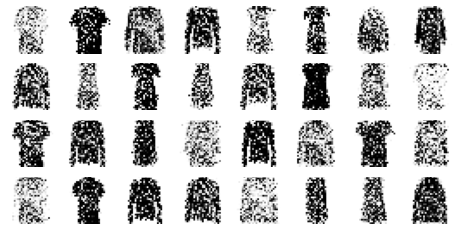

Epoch 10/50


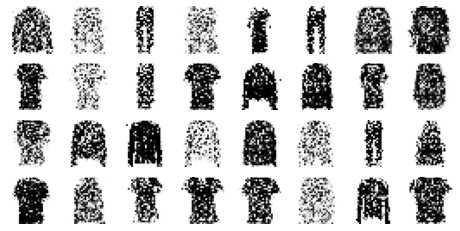

Epoch 11/50


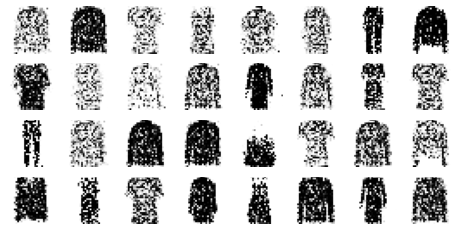

Epoch 12/50


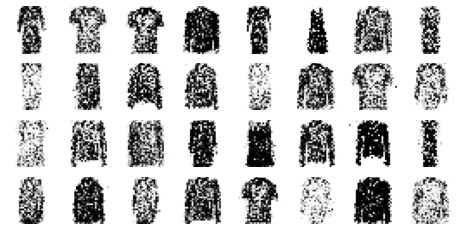

Epoch 13/50


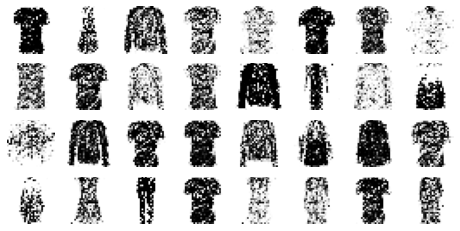

Epoch 14/50


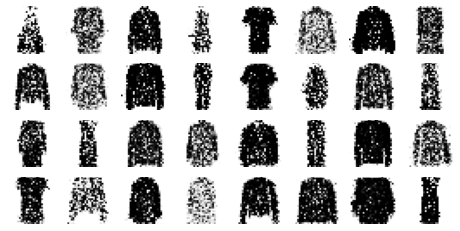

Epoch 15/50


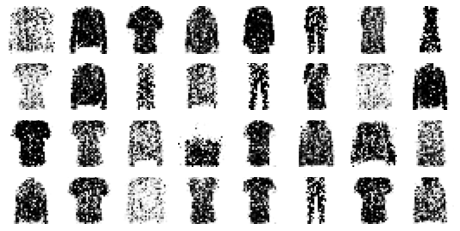

Epoch 16/50


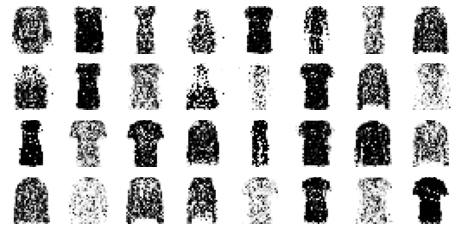

Epoch 17/50


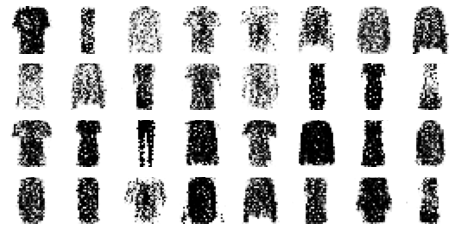

Epoch 18/50


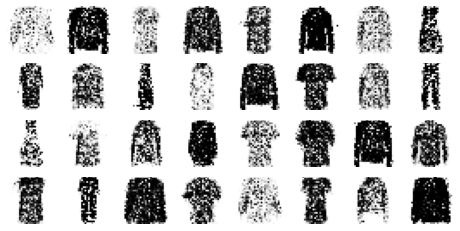

Epoch 19/50


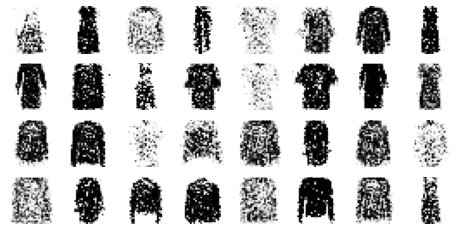

Epoch 20/50


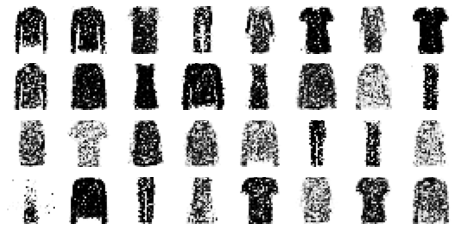

Epoch 21/50


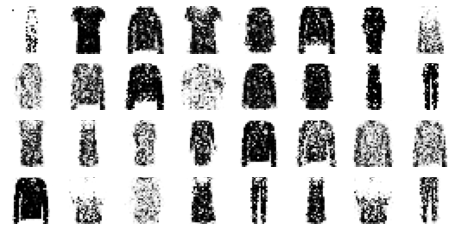

Epoch 22/50


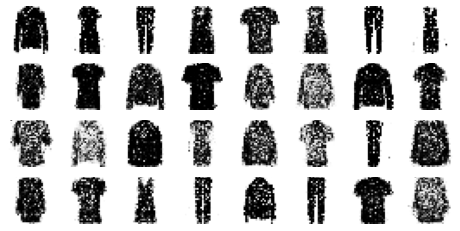

Epoch 23/50


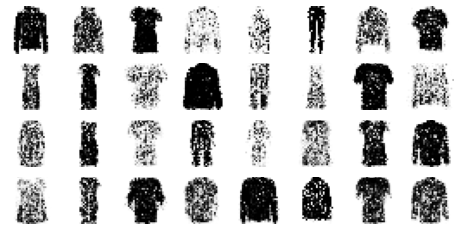

Epoch 24/50


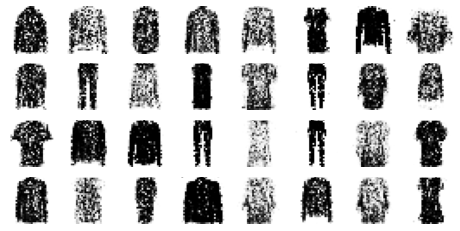

Epoch 25/50


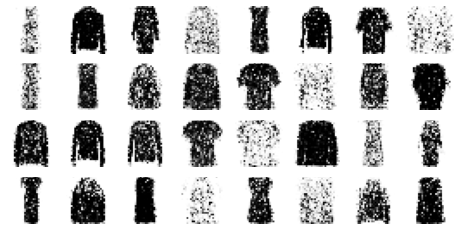

Epoch 26/50


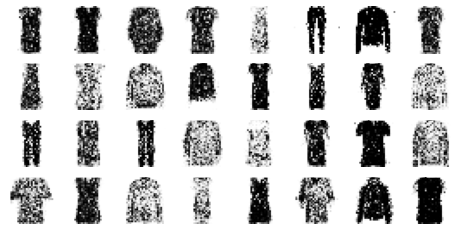

Epoch 27/50


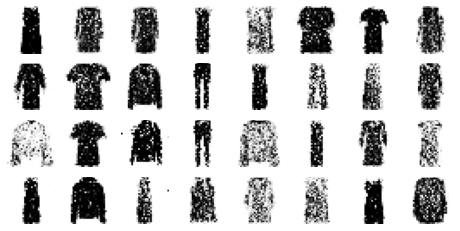

Epoch 28/50


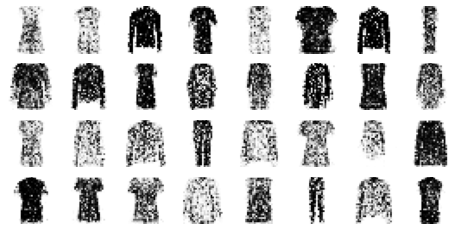

Epoch 29/50


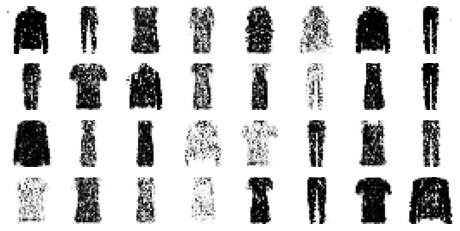

Epoch 30/50


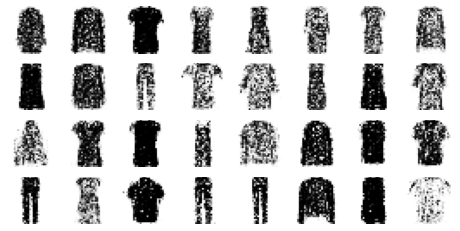

Epoch 31/50


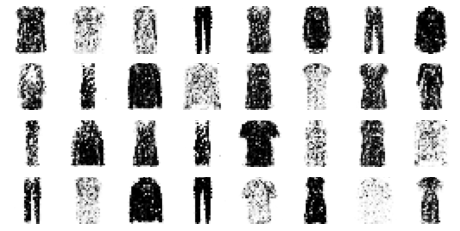

Epoch 32/50


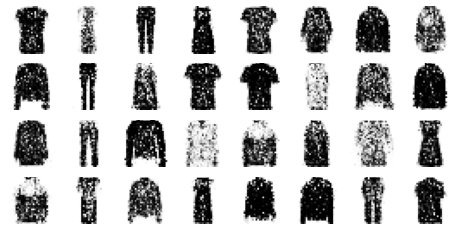

Epoch 33/50


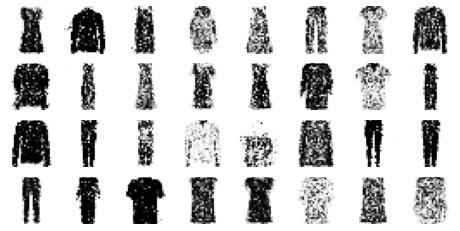

Epoch 34/50


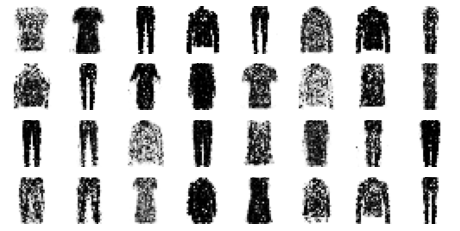

Epoch 35/50


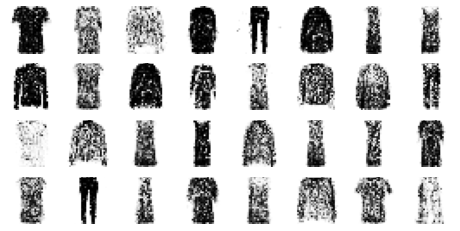

Epoch 36/50


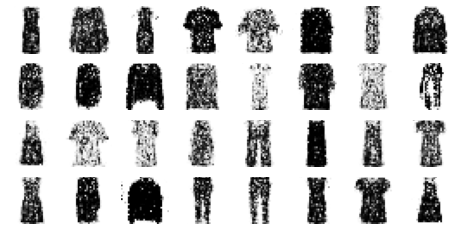

Epoch 37/50


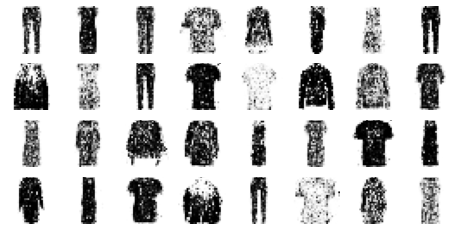

Epoch 38/50


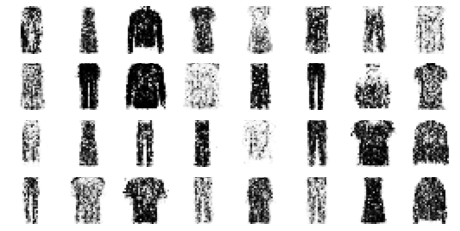

Epoch 39/50


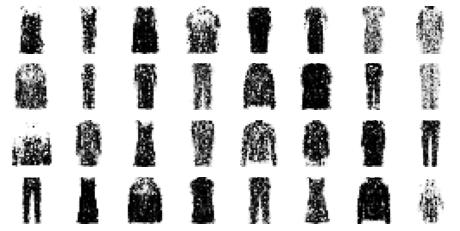

Epoch 40/50


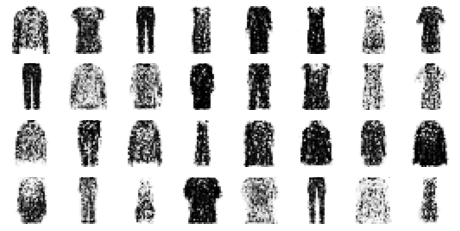

Epoch 41/50


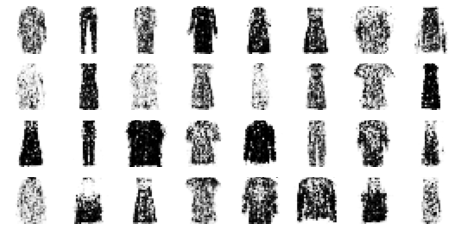

Epoch 42/50


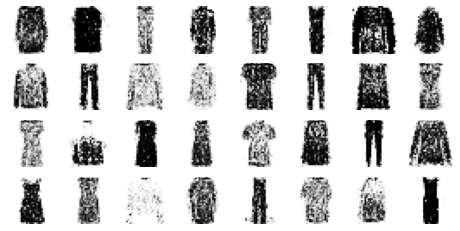

Epoch 43/50


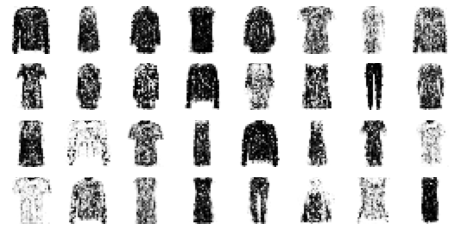

Epoch 44/50


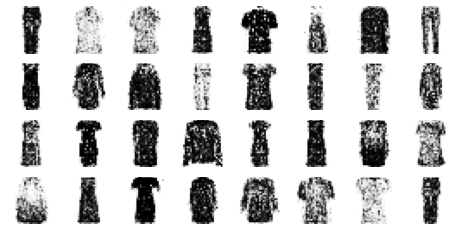

Epoch 45/50


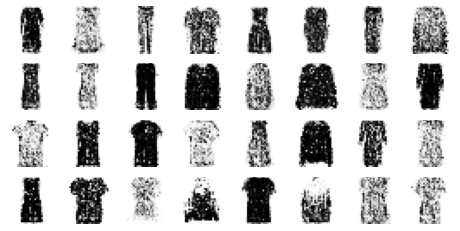

Epoch 46/50


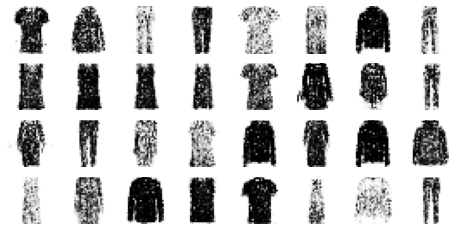

Epoch 47/50


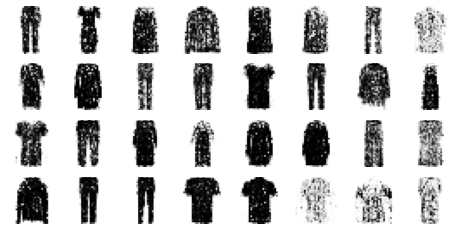

Epoch 48/50


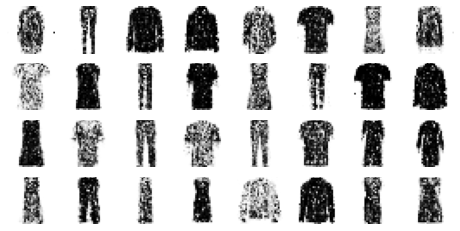

Epoch 49/50


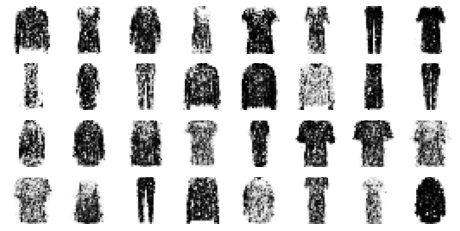

Epoch 50/50


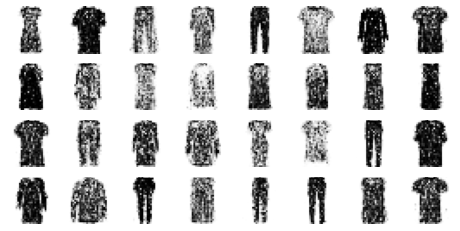

In [11]:
train_gan(gan, dataset, batch_size, codings_size)